In [51]:
library(tidyverse)
library(boot)
library(simpleboot)
library(openxlsx)

The above code loads necessary libraries needed for data manipulation, bootstrapping, and exporting tables to use in my report. My comments will be made below each code block to minimize confusion.

In [50]:
pitches = read_csv("pitches1418.csv")

I import the data from an excel sheet downloaded off of kaggle.

In [3]:
fastballs = pitches %>% filter(pitch_type == "FF")
fastballs = fastballs %>% 
mutate(release_point = pz + tan(ay*pi/180)/90, yrchar = as.character(ab_id), yr = str_extract(yrchar, "\\d\\d\\d\\d"), yrbn = ifelse(yr == "2015", 0, 1))


I am manipulating the data to get the necessary variables for my analysis.

In [4]:
#tbl1 = fastballs %>% select(yr, pz, ay, release_point, end_speed) %>% head
#write.xlsx(tbl1, "tbl1.xlsx") 
#tbl2 = fastballs %>% select(yr, pz, ay, release_point, end_speed) %>% group_by(yr) %>% summarize_all(mean)
#write.xlsx(tbl2, "tbl2.xlsx") 

These are the first two tables in my report.

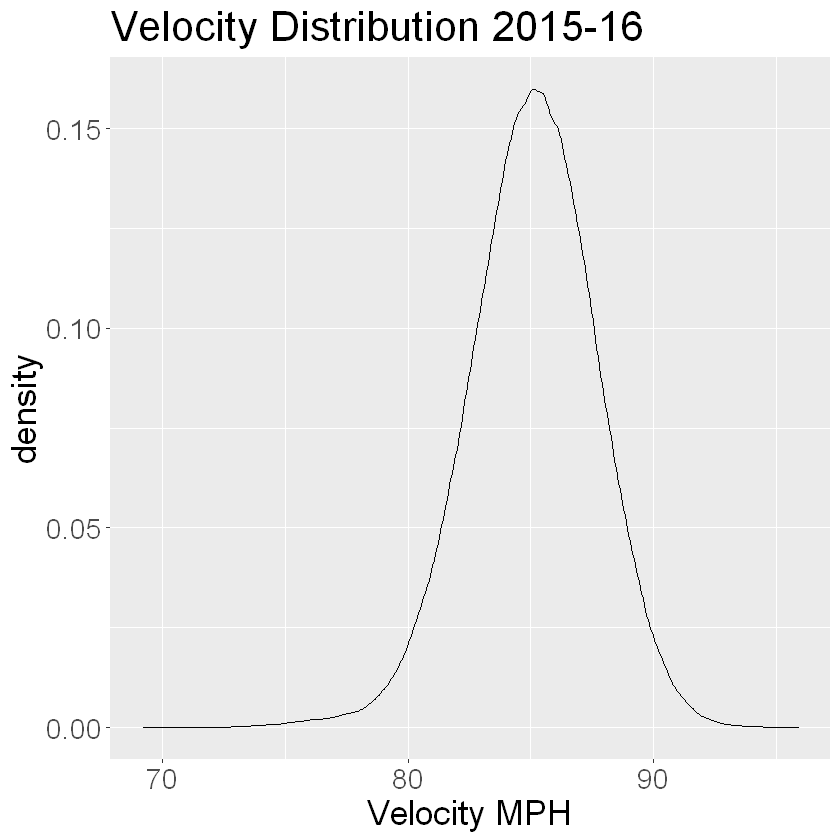

In [62]:
ggplot(fastballs) + geom_density(aes(end_speed)) + labs(x = "Velocity MPH", title = "Velocity Distribution 2015-16") +theme(text=element_text(size=21))

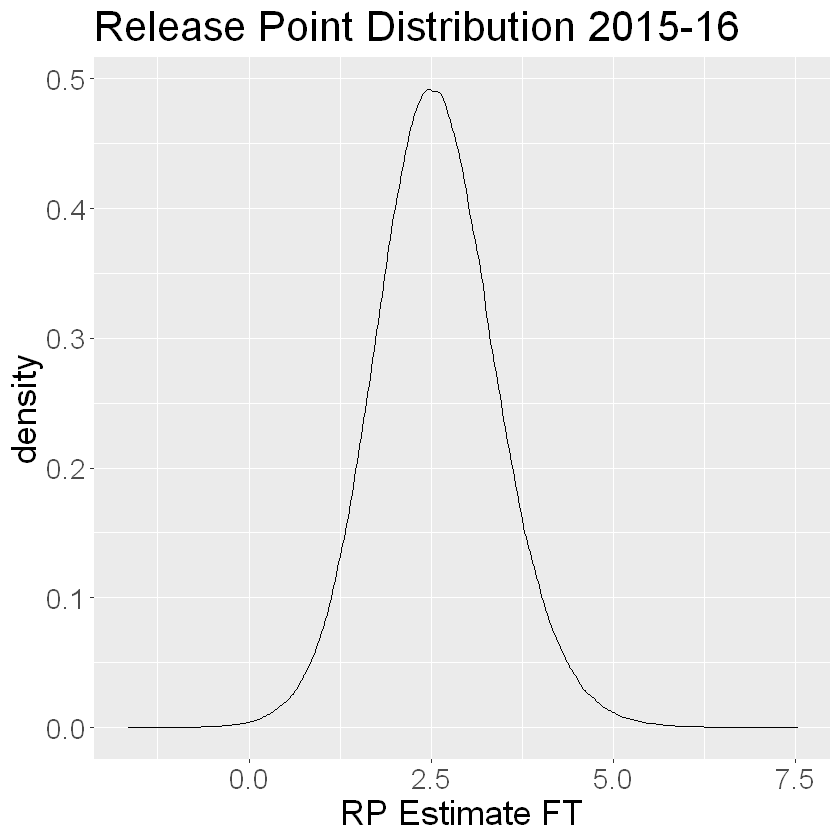

In [63]:
ggplot(fastballs) + geom_density(aes(release_point)) + labs(x = "RP Estimate FT", title = "Release Point Distribution 2015-16") +theme(text=element_text(size=21))

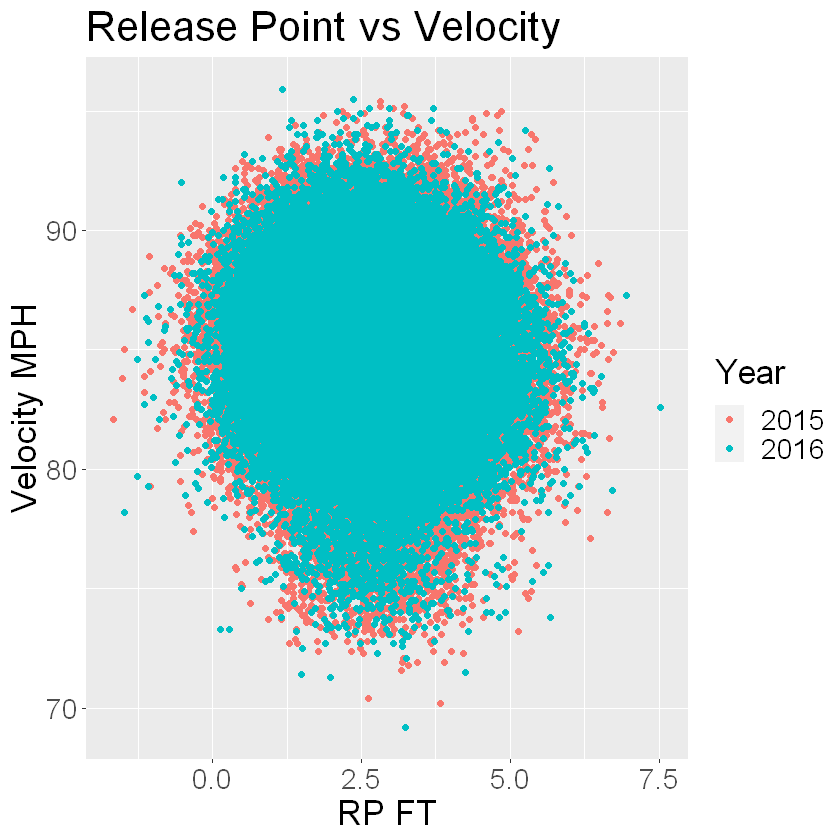

In [64]:
ggplot(fastballs) + geom_point(aes(x = release_point, y = end_speed, color = yr))+theme(text=element_text(size=21)) + labs(x = "RP FT", y = "Velocity MPH", title = "Release Point vs Velocity", color = "Year")

In [8]:
n = length(fastballs$pz)
y = seq(1,n,1)
w = c(rank(fastballs$release_point), y)
z = c(rep(0, n), rep(1, n))
teststat = function(w,z) {
    f <- w[z == 1]
    g <- w[z == 0]
    mean(f / g)
}
that = teststat(w,z)
perms = replicate(80, sample(z))

tb = apply(perms, 2, function(zstar){teststat(w, zstar)})



This block defines uses permutation to get a distribution for $T = f(H)/Y$ as described in my report. I use the w-z approach as described in lecture. T hat is used for error analyis while tb is the T distribution used in further analysis.

In [9]:
f = function(x, a) {
    xun = unlist(x)
    map_dbl(xun,~ log(.x*a))
}

g = function(x, n){
    xun = unlist(x)
    map_dbl(xun, ~ {
       rtn = 1;
       while(n != 0){
           rtn = rtn + .x^n
           n = n- 1
       }
       return(rtn)
    })
}


f is the logarithmic function with an argument of constant a multiplied by f's argument used to estimate pitch speed. g is the nth degree polynomial, defined recursively, used to estimate player height.

In [25]:

size = dim(fastballs)[1]
half = round(n/2)
fastballs$YT = fastballs$release_point * sample(tb, size, replace = TRUE)
errfYT = function(n) {
    fastballs$YTfuncinit = g(fastballs$YT, n)
    rand.order = sample.int(size)
    fastballs$YTsample = sample(fastballs$YT)
    fastballs$YTfunc = g(fastballs$YTsample, n)
    train = rand.order[1:half]
    test = rand.order[(half+1):size]
    mod = lm(YTfuncinit ~ YTfunc, fastballs[train,])
    preds = predict(mod, newdata = fastballs[test,])
    meanerr = mean(fastballs$YTfuncinit[test] - preds)
    list(preds, (fastballs$YTfuncinit[test] - preds)^2, mod$coefficients)
}


Here I use train/test cross-validation to estimate predicted heights, errors, and parameters. My linear model is the predicted height from one sample as a function of the permuted predicted height.

In [26]:
errpspeed = function(a, n) {
    rand.order = sample.int(size)
    train = rand.order[1:half]
    test = rand.order[(half+1):size]
    mod = lm(fastballs$end_speed[train] ~ f(errfYT(n)[1], a))
    newpreds = predict(mod, newdata = fastballs[test,])
    meanerrs = mean(fastballs$end_speed[test] - newpreds)
    list(newpreds, unlist(fastballs$end_speed[test] - newpreds)^2, mod$coefficients)
    
}


This is the cross-validation for predicted speed, errors, and parameters. The linear model is speed data vs predicted height.

In [60]:
smalllen = length(fastballs$end_speed[fastballs$yrbn == 1])
sizecorr = sample(fastballs$end_speed[fastballs$yrbn == 0], smalllen, replace = FALSE)
meandiff = two.boot(fastballs$end_speed[fastballs$yrbn == 1], sizecorr, mean, R = 1000)
meddiff = two.boot(fastballs$end_speed[fastballs$yrbn == 1], sizecorr, median, R = 1000)
smallint = meandiff
ci = boot.ci(smallint, conf = 0.95, type = "norm")
c12 = boot.ci(meddiff, conf = 0.95, type = "norm")
ci

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = smallint, conf = 0.95, type = "norm")

Intervals : 
Level      Normal        
95%   (-0.0193,  0.0228 )  
Calculations and Intervals on Original Scale

In [61]:
c12

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = meddiff, conf = 0.95, type = "norm")

Intervals : 
Level      Normal        
95%   (-0.0358,  0.0446 )  
Calculations and Intervals on Original Scale

This is my parameterized bootstrap for pitch speed as a function of time. I accepted the null hypothesis that there was no correlation.

In [13]:
avec5 = c()
nvec5 = c()
errfvec5 = c()
errpvec5 = c()
for(a in 1:3){
    for(n in 1:3){

            avec5 = c(avec5, a)
            nvec5 = c(nvec5, n)
            errfvec5 = c(errfvec5, mean(unlist(errfYT(n)[2])), na.rm = TRUE)
            errpvec5 = c(errpvec5, mean(unlist(errpspeed(a,n)[2])), na.rm = TRUE)

    }
}
combrank5 = rank(errfvec5, ties.method = "first") + rank(errpvec5, ties.method = "first")
c("a", avec5[which.max(combrank5)],"n",  nvec5[which.max(combrank5)])

[1] "a" "2" "n" "2"

Here is the main algorithm. I iterate through a-n combos to find the combo that minimizes errors from the two CVs. The ranking system allows for a scaled balance. 

In [28]:
err = errfYT(2)
Hpreds = unlist(err[1])
Herr = unlist(err[2])
Hpar = unlist(err[3])

errA = errpspeed(2,2)
Apreds = unlist(errA[1])
Aerr = unlist(errA[2])
Apar = unlist(errA[3])

These are descriptive statistics for the a-n combo of 2 and 2. They are labeled and printed below.

In [56]:
(c("Pred. Mean", mean(Hpreds, na.rm = TRUE),"Pred. Var", var(Hpreds, na.rm = TRUE), "MSE", mean(Herr, na.rm = TRUE),"Model Coefs", Hpar))

"Pred. Mean"  "111.847498503522"         "Pred. Var"  "110.194068122155" 
                                                                    (Intercept) 
              "MSE"  "25385.7980068143"       "Model Coefs"  "125.349907920767" 
             YTfunc 
"-0.07382004273098"

The label is to the left of the value. These are for the height estimation. I couldn't find a way to remove the names.

In [58]:
c("Pred. Mean",mean(Apreds, na.rm = TRUE), "Pred. Var",var(Apreds, na.rm = TRUE),"MSE", mean(Aerr, na.rm = TRUE),"Model Coefs" ,Apar)

"Pred. Mean"     "85.0559526943937"            "Pred. Var" 
                                                                     
"3.21513885230705e-08"                  "MSE"     "6.68315774688053" 
                                  (Intercept)     f(errfYT(n)[1], a) 
         "Model Coefs"     "84.5872430719731"   "0.0794033543361863"

For the velocity estimate.

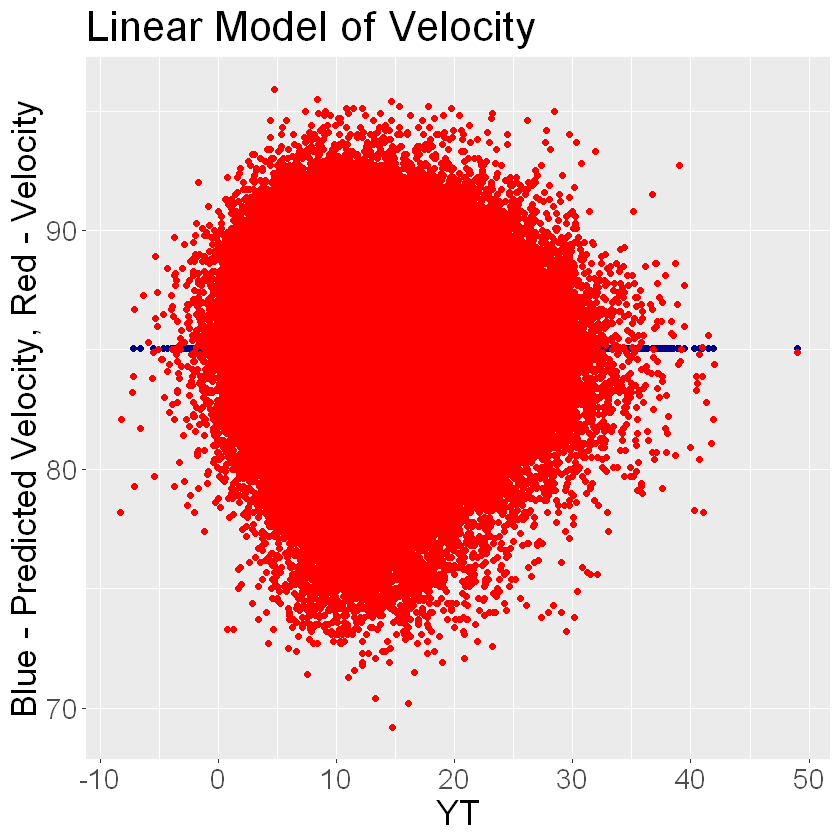

In [53]:
ggplot() + geom_point(aes(x = YThalf, y = Apreds), color = "darkblue") + geom_point(aes(x = fastballs$YT, y = fastballs$end_speed), color = "red") + labs(x = "YT", y = "Blue - Predicted Velocity, Red - Velocity", title = "Linear Model of Velocity")+theme(text=element_text(size=21)) 